## Importing necessary libraries:

In [1]:
import os
import pygame
DISPLAY = True
if not DISPLAY:
    os.environ["SDL_VIDEODRIVER"] = "dummy"

pygame 2.5.2 (SDL 2.28.3, Python 3.11.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
import os, sys
sys.path.append('game/')
import flappy_wrapped as game
import cv2
import numpy as np
import time
%matplotlib inline
import matplotlib.pyplot as plt
import collections
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device( "cuda" if torch.cuda.is_available() else "cpu" )

## Khai bao siêu tham số


In [3]:
# Action of Agent
ACTIONS = [0,1]
# Size of buffer experience
EXPERIENCE_BUFFER_SIZE = 2000
# Number of images in one train
STATE_DIM = 4
# Gamma
GAMMA = 0.99
# Epsilon, decreasing with each epochs
EPSILON_START = 1
EPSILON_FINAL = 0.001
EPSILON_DECAY_FRAMES = (10**4)/3
# Number of goals to achieve
MEAN_GOAL_REWARD = 10
# Batch_size: Number of buffers per training session
BATCH_SIZE = 32
# Minimum amount of Buffer Experience memory to be able to train
MIN_EXP_BUFFER_SIZE = 500
# Frame frequency to synchronize Target Network for Online Network
SYNC_TARGET_FRAMES = 30
# learning rate
LEARNING_RATE = 1e-4
# skip_frame: number of frames performed with the previous action
SKIP_FRAME = 2
# Policy for each game's restart.
INITIAL_SKIP = [0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,1,0,1]
# Maximum number of training epochs
EPOCHS_MAX = 5000

## Defining function used to preprocess game frame data (converting to grayscale):

In [4]:
KERNEL = np.array([[-1,-1,-1], [-1, 9,-1],[-1,-1,-1]])
IMAGE_SIZE = 84
def processFrame(image):
    # env.SCREENWIDTH = 288
    # env.BASEY = 404
    frame = image[55:288, :404] # crop image ->
    frame = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY) # convert image to black and white
    frame = cv2.resize(frame,(IMAGE_SIZE,IMAGE_SIZE),interpolation=cv2.INTER_AREA)
    _ , frame = cv2.threshold(frame,50,255,cv2.THRESH_BINARY)
    frame = cv2.filter2D(frame,-1,KERNEL)
    frame = frame.astype(np.float64)/255.0
    return frame

## Creat Agent, ExperienceBuffer, Loss

In [5]:
class Agent():
    def __init__(self,env,buffer,t_model="DQN",state_buffer_size = STATE_DIM):
        self.env = env  # game Flappy Bird
        self.exp_buffer = buffer    # memory buffer
        self.t_model = t_model      # choose Agent for model: DQN or DDQN with PER
        self.state_buffer_size = state_buffer_size  # Number of images in the buffer one train
        self.state = collections.deque(maxlen = self.state_buffer_size)
        self.next_state= collections.deque(maxlen = self.state_buffer_size)
        self._reset()
    
    # Restart game with fix start policy in INITIAL_SKIP
    def _reset(self):
        self.total_rewards = 0
        self.state.clear()
        self.next_state.clear()
        
        for i in INITIAL_SKIP[:-7]:
            image,reward,done = self.env.frame_step(i)
            self.total_rewards+=reward
            if done:
                self._reset()
        frame = processFrame(image)
        self.state.append(frame)
        self.next_state.append(frame)

        for i in INITIAL_SKIP[-7:-5]:
            image,reward,done = self.env.frame_step(i)
            self.total_rewards+=reward
            if done:
                self._reset()
        frame = processFrame(image)
        self.state.append(frame)
        self.next_state.append(frame)
        
        for i in INITIAL_SKIP[-5:-3]:
            image,reward,done = self.env.frame_step(i)
            self.total_rewards+=reward
            if done:
                self._reset()
        frame = processFrame(image)
        self.state.append(frame)
        self.next_state.append(frame)
        
        for i in INITIAL_SKIP[-3:-1]:
            image,reward,done = self.env.frame_step(i)
            self.total_rewards+=reward
            if done:
                self._reset()
        frame = processFrame(image)
        self.state.append(frame)
        self.next_state.append(frame)
    
    # Agent takes a action -> Return reward.
    def step(self,net,tgt_net,epsilon=0.9,device='cpu'):
        # reward in this step
        self.total_rewards = 0
        # Exploration - Exploitation
        if np.random.random() < epsilon:
            action = np.random.choice(ACTIONS)
        else:
            state_v = torch.tensor(np.array([self.state],copy=False),dtype=torch.float32).to(device)
            action = int(torch.argmax(net(state_v)))
        # Take action
        image,reward,done = self.env.frame_step(action)
        self.total_rewards += reward
        # Take with same previous action for SKIP_FRAME next frame.
        for _ in range(SKIP_FRAME):
                image,reward,done =  self.env.frame_step(action)
                self.total_rewards += reward
                if done:
                    break
                    
        frame = processFrame(image)
        self.next_state.append(frame)
        # Add buffer to memory Experience Buffer
        # If DQN: (state, action, reward, done, next_state)
        # If PER: ((state, action, reward, done, next_state), p)
        if len(self.next_state)==self.state_buffer_size and len(self.state)==self.state_buffer_size:
            if self.t_model == "DQN":
                self.exp_buffer.append((self.state.copy(),action,int(self.total_rewards),done,self.next_state.copy()))
            else:
                #PER - Prioritized Experience Replay
                # o = 
                o = net( torch.tensor( np.array([self.state]),dtype=torch.float32).to(device)).to('cpu').detach().numpy()[0][action]
                e = float(torch.max(tgt_net( torch.tensor( np.array([self.next_state]),dtype=torch.float32).to(device))))
                p = abs(o-e)+0.0001
                self.exp_buffer.append((self.state.copy(),action,int(self.total_rewards),done,self.next_state.copy()),p)
        
        self.state.append(frame)
        
        end_reward = int(self.total_rewards)
        if done:
            self._reset()
        
        return end_reward

In [6]:
class ExperienceBuffer():
    # initial memory buffer
    def __init__(self,capacity):
        self.buffer = collections.deque(maxlen=capacity)
    # clear memory buffer
    def clear(self):
        self.buffer.clear()
        
    def __len__(self):
        return len(self.buffer)
    
    def append(self,exp):
        self.buffer.append(exp)
    # get sample in memory buffer with size=batch_size
    def sample(self,batch_size):
        indices = np.random.choice( range(len(self.buffer)), batch_size)
        states,actions,rewards,dones,next_states = zip(*[ self.buffer[idx] for idx in indices ])
        return np.array(states), np.array(actions), np.array(rewards, dtype=np.float32),\
    np.array(dones,dtype=np.uint8), np.array(next_states)

In [7]:
class ExperienceBufferPER():
    # initial memory buffer and priority
    def __init__(self,capacity):
        self.buffer = collections.deque(maxlen=capacity)
        self.priority = collections.deque(maxlen=capacity)
    # clear memory buffer and priority
    def clear(self):
        self.buffer.clear()
        self.priority.clear()
        
    def __len__(self):
        return len(self.buffer)
    
    def append(self,exp,p):
        self.buffer.append(exp)
        self.priority.append(p)
    # get sample in memory buffer with size=batch_size with probability based on priority
    def sample(self,batch_size):
        probs = np.array(self.priority)/sum(np.array(self.priority))
        indices = np.random.choice( range(len(self.buffer)), batch_size, p = probs)
        states,actions,rewards,dones,next_states = zip(*[ self.buffer[idx] for idx in indices ])
        return np.array(states), np.array(actions), np.array(rewards, dtype=np.float32),\
    np.array(dones,dtype=np.uint8), np.array(next_states)

In [8]:
def calc_loss_DQN(batch,net,device='cpu'):
    # get data from batch (choosed in memory) and conver to torch Tensor and device
    states,actions,rewards,dones,next_states = batch
    states_v = torch.tensor(states,dtype=torch.float32).to(device)
    actions_v = torch.tensor(actions,dtype=torch.long).to(device)
    rewards_v = torch.tensor(rewards).to(device)
    dones_v = torch.ByteTensor(dones).to(device)
    next_states_v = torch.tensor(next_states,dtype=torch.float32).to(device)
    # Predict Q values for state
    state_action_values = net(states_v).gather(1, actions_v.unsqueeze(-1)).squeeze(-1)
    # Predict values for next state
    with torch.no_grad():
        next_state_action_values = net(next_states_v)
    # Q values with Bellman Equation 
    next_state_action_values = rewards_v + GAMMA * ((1-dones_v)*torch.max(next_state_action_values,dim=1)[0])
    expected_values = next_state_action_values.detach() 
    # retun loss
    return nn.MSELoss()(state_action_values,expected_values)

In [9]:
def calc_loss_DDQN(batch,net,tgt_net,device='cpu'):
    # get data from batch (choosed in memory) and conver to torch Tensor and device
    states,actions,rewards,dones,next_states = batch
    states_v = torch.tensor(states,dtype=torch.float32).to(device)
    actions_v = torch.tensor(actions,dtype=torch.long).to(device)
    rewards_v = torch.tensor(rewards).to(device)
    dones_v = torch.ByteTensor(dones).to(device)
    next_states_v = torch.tensor(next_states,dtype=torch.float32).to(device)
    # Predict Q values for state by online network
    state_action_values = net(states_v).gather(1, actions_v.unsqueeze(-1)).squeeze(-1)
    # Predict Q values for state by target network
    next_state_action_values = tgt_net(next_states_v).max(1)[0]
    # next_state_action_values[dones_v] = 0.0
    next_state_action_values = next_state_action_values.detach() 
    expected_values = rewards_v +  next_state_action_values * GAMMA
    # retun loss
    return nn.MSELoss()(state_action_values,expected_values)

## DQN Models

### Deep Q-Network

In [10]:
#@title Model DQN
class DQN(nn.Module):
    def __init__(self, input_shape=[4,84,84], nactions=2):
        super(DQN, self).__init__()
        self.nactions = nactions
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0],32,kernel_size=4,stride=2),
            nn.ReLU(),
            nn.Conv2d(32,64,kernel_size=3,stride=2),
            nn.ReLU(),
            nn.Conv2d(64,64,kernel_size=2,stride=1),
            nn.ReLU()
        )

        conv_out_size = self._get_conv_out(input_shape)

        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, nactions)
        )

    def _get_conv_out(self,shape):
        o = self.conv( torch.zeros(1,*shape) )
        return int(np.prod(o.size()))

    def forward(self, x):
        conv_out = self.conv(x).view(x.size()[0], -1)
        x = self.fc(conv_out)

        return x

In [ ]:

model = DQN()
import torchvision
from torchview import draw_graph

model_graph = draw_graph(model, input_size=(1,3,224,224), expand_nested=True)
model_graph.visual_graph

: 

### Dueling DQN

In [12]:
#@title Model Dueling DQN
class DDQN(nn.Module):
    def __init__(self,input_shape,nactions):
        super(DDQN,self).__init__()
        self.nactions = nactions
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0],32,kernel_size=4,stride=2),
            nn.ReLU(),
            nn.Conv2d(32,64,kernel_size=3,stride=2),
            nn.ReLU(),
            nn.Conv2d(64,64,kernel_size=2,stride=1),
            nn.ReLU()
        )
        
        conv_out_size = self._get_conv_out(input_shape)
        
        self.fca = nn.Sequential(
            nn.Linear( conv_out_size, 512),
            nn.ReLU(),
            nn.Linear( 512, nactions )
        )
        
        self.fcv = nn.Sequential(
            nn.Linear(conv_out_size,512),
            nn.ReLU(),
            nn.Linear(512,1)
        )
        
    def _get_conv_out(self,shape):
        o = self.conv( torch.zeros(1,*shape) )
        return int(np.prod(o.size()))
    
    def forward(self,x):
        conv_out = self.conv(x).view(x.size()[0], -1)
        action_v = self.fca(conv_out)
        value_v = self.fcv(conv_out).expand(x.size(0), self.nactions)
        return value_v + action_v - action_v.mean(1).unsqueeze(1).expand(x.size(0), self.nactions)

## Training

### DQN with experience replay

In [13]:
# Memory to save data log (loss, epsilons and rewards) during training
all_losses = []
all_epsilons = []
all_rewards = []
# Define network
net = DQN((STATE_DIM,IMAGE_SIZE,IMAGE_SIZE), len(ACTIONS)).to(device)
# Initialize the environment, Agent
env = game.GameState()
buffer = ExperienceBuffer(EXPERIENCE_BUFFER_SIZE) # Using ExperienceBuffer with DQN
agent = Agent(env,buffer,t_model="DQN") # Using Agent with DQN
epsilon = EPSILON_START
optimizer = optim.Adam(net.parameters(),lr=LEARNING_RATE)
total_rewards = []  # List of rewards during training
best_mean_reward = float('-inf')    # value best_mean_reward 
last_mean = float('-inf')   # the last mean_reward is saved
game_id = 0 # number of games played
while game_id < EPOCHS_MAX:
    # Set epsilon, decreasing with each epochs
    epsilon = max( EPSILON_FINAL , EPSILON_START - game_id/EPSILON_DECAY_FRAMES )
    # take action
    reward = agent.step(net,0,epsilon,device=device)
    if reward != 0: # when die or overcome obstacles
        game_id += 1
        total_rewards.append(reward)
        mean_reward = np.mean(total_rewards[-100:]) # get mean reward from the last 100 reward changes
        if game_id%10 == 0:
            print("GAME : {} | EPSILON : {:.4f} | MEAN REWARD : {}".format( game_id, epsilon, mean_reward ))
        if best_mean_reward < mean_reward:  # save best_mean_reward
            best_mean_reward = mean_reward
            
            if best_mean_reward - last_mean >= 0.1: # save last mean_reward and model parameter when mean_reward increase by at least 0.1
                torch.save(net.state_dict(),'checkpoints/best_DQN.dat')
                print("REWARD {} -> {}. Model Saved".format(last_mean,mean_reward))
                last_mean = best_mean_reward
        # Stop training when achieve the set target number
        if mean_reward >= MEAN_GOAL_REWARD:
            print("Learned in {} Games.".format(game_id))
            break
    # Save the minimum number of buffers to be able to perform training
    if len(buffer) < MIN_EXP_BUFFER_SIZE:
        continue
    # Training
    optimizer.zero_grad()
    batch = buffer.sample(BATCH_SIZE)   # get sample with BATCH_SIZE buffers
    loss_t = calc_loss_DQN(batch,net,device=device) # Using calc_loss_DQN with DQN
    all_losses.append(float(loss_t))
    all_epsilons.append(float(epsilon))
    all_rewards.append(mean_reward)
    loss_t.backward()
    optimizer.step()


# dictionary of lists
dict = {'Loss': all_losses, 'Epsilon': all_epsilons, 'Reward': all_rewards}
# saving the dataframe
df = pd.DataFrame(dict)
# save to .csv
df.to_csv('log/DQN.csv')


REWARD -inf -> -1.0. Model Saved
GAME : 10 | EPSILON : 0.9973 | MEAN REWARD : -1.0
GAME : 20 | EPSILON : 0.9943 | MEAN REWARD : -1.0
GAME : 30 | EPSILON : 0.9913 | MEAN REWARD : -1.0
GAME : 40 | EPSILON : 0.9883 | MEAN REWARD : -1.0
REWARD -1.0 -> -0.9534883720930233. Model Saved
REWARD -0.9534883720930233 -> -0.9166666666666666. Model Saved
GAME : 50 | EPSILON : 0.9853 | MEAN REWARD : -0.92
GAME : 60 | EPSILON : 0.9823 | MEAN REWARD : -0.9333333333333333
GAME : 70 | EPSILON : 0.9793 | MEAN REWARD : -0.9428571428571428
GAME : 80 | EPSILON : 0.9763 | MEAN REWARD : -0.95
GAME : 90 | EPSILON : 0.9733 | MEAN REWARD : -0.9333333333333333
GAME : 100 | EPSILON : 0.9703 | MEAN REWARD : -0.94
GAME : 110 | EPSILON : 0.9673 | MEAN REWARD : -0.94
GAME : 120 | EPSILON : 0.9643 | MEAN REWARD : -0.94
GAME : 130 | EPSILON : 0.9613 | MEAN REWARD : -0.94
GAME : 140 | EPSILON : 0.9583 | MEAN REWARD : -0.94
GAME : 150 | EPSILON : 0.9553 | MEAN REWARD : -0.98
GAME : 160 | EPSILON : 0.9523 | MEAN REWARD : -

KeyboardInterrupt: 

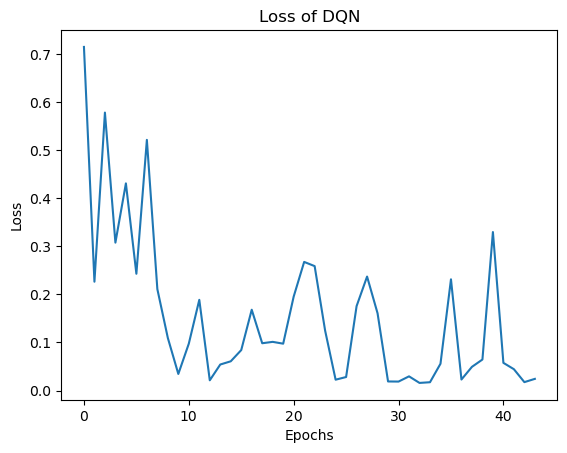

In [80]:
plt.title("Loss of DQN")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(all_losses)
plt.savefig('log/Loss_DQN.png')

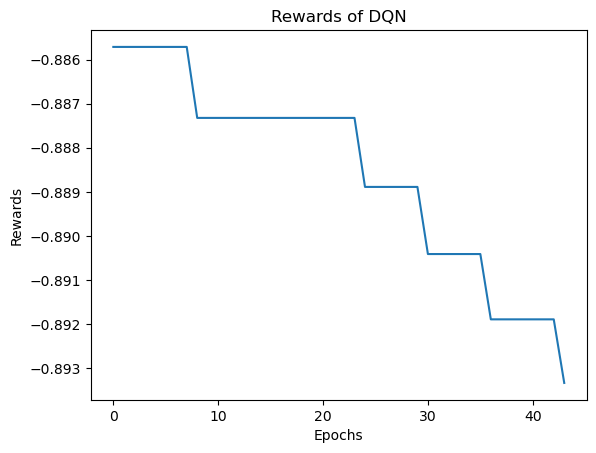

In [82]:
plt.title("Rewards of DQN")
plt.xlabel("Epochs")
plt.ylabel("Rewards")
plt.plot(all_rewards)
plt.savefig('log/Reward_DQN.png')


### Double DQN


In [ ]:
#@title Double DQN

all_losses = []
all_epsilons = []
all_rewards = []


net = DQN( (STATE_DIM,84,84), len(ACTIONS) ).to(device)
tgt_net = DQN( (STATE_DIM,84,84), len(ACTIONS) ).to(device) # have Target Network

env = game.GameState()
buffer = ExperienceBuffer(EXPERIENCE_BUFFER_SIZE) # Using ExperienceBuffer with DQN
agent = Agent(env,buffer) # Using Agent with DQN
epsilon = EPSILON_START
optimizer = optim.Adam(net.parameters(),lr=LEARNING_RATE)

total_rewards = []
best_mean_reward = float('-inf')
last_mean = float('-inf')
game_id = 0
while game_id < EPOCHS_MAX:
    epsilon = max( EPSILON_FINAL , EPSILON_START - game_id/EPSILON_DECAY_FRAMES )
    
    reward = agent.step(net,tgt_net,epsilon,device=device)
    if reward != 0:
        game_id += 1
        total_rewards.append(reward)
        mean_reward = np.mean(total_rewards[-100:])
        if game_id%5 == 0:
            print("GAME : {} | EPSILON : {:.4f} | MEAN REWARD : {}".format( game_id, epsilon, mean_reward ))
        if best_mean_reward < mean_reward:
            best_mean_reward = mean_reward
            
            if best_mean_reward - last_mean >= 0.1:
                torch.save(net.state_dict(),'checkpoints/best_DDQN.dat')
                print("REWARD {} -> {}. Model Saved".format(last_mean,mean_reward))
                last_mean = best_mean_reward

        if game_id % SYNC_TARGET_FRAMES == 0:
            tgt_net.load_state_dict(net.state_dict())
            
        if mean_reward >= MEAN_GOAL_REWARD:
            print("Learned in {} Games.".format(game_id))
            break
    
    if len(buffer) < MIN_EXP_BUFFER_SIZE:
        continue
    
    optimizer.zero_grad()
    batch = buffer.sample(BATCH_SIZE)
    loss_t = calc_loss_DDQN(batch,net,tgt_net,device=device)    # Using calc_loss_DDQN with DDQN
    all_losses.append(float(loss_t))
    all_epsilons.append(float(epsilon))
    all_rewards.append(mean_reward)
    loss_t.backward()
    optimizer.step()

# dictionary of lists
dict = {'Loss': all_losses, 'Epsilon': all_epsilons, 'Reward': all_rewards}
# saving the dataframe
df = pd.DataFrame(dict)
# save to .csv
df.to_csv('log/DDQN.csv')

In [ ]:
plt.title("Loss of DDQN")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(all_losses)
plt.savefig('log/Loss_DDQN.png')

In [ ]:
plt.title("Rewards of DDQN")
plt.xlabel("Epochs")
plt.ylabel("Rewards")
plt.plot(all_rewards)
plt.savefig('log/Reward_DDQN.png')

### Dueling DDQN with Prioritized Experience Replay

In [68]:
#@title Dueling DDQN with 

all_losses = []
all_epsilons = []
all_rewards = []


net = DDQN( (STATE_DIM,84,84), len(ACTIONS) ).to(device)
tgt_net = DDQN( (STATE_DIM,84,84), len(ACTIONS) ).to(device)

env = game.GameState()
buffer = ExperienceBufferPER(EXPERIENCE_BUFFER_SIZE)    # Using ExperienceBufferPER with PER
agent = Agent(env,buffer, t_model="PER")    # Using Agent with PER
epsilon = EPSILON_START
optimizer = optim.Adam(net.parameters(),lr=LEARNING_RATE)

total_rewards = []
best_mean_reward = float('-inf')
last_mean = float('-inf')
game_id = 0
while game_id < EPOCHS_MAX:
    epsilon = max( EPSILON_FINAL , EPSILON_START - game_id/EPSILON_DECAY_FRAMES )
    
    reward = agent.step(net,tgt_net,epsilon,device=device)
    if reward != 0:
        game_id += 1
        total_rewards.append(reward)
        mean_reward = np.mean(total_rewards[-100:])
        if game_id%5 == 0:
            print("GAME : {} | EPSILON : {:.4f} | MEAN REWARD : {}".format( game_id, epsilon, mean_reward ))
        if best_mean_reward < mean_reward:
            best_mean_reward = mean_reward
            
            if best_mean_reward - last_mean >= 0.1:
                torch.save(net.state_dict(),'checkpoints/best_DuelingDQN_PER.dat')
                print("REWARD {} -> {}. Model Saved".format(last_mean,mean_reward))
                last_mean = best_mean_reward

        if game_id % SYNC_TARGET_FRAMES == 0:
            tgt_net.load_state_dict(net.state_dict())
            
        if mean_reward >= MEAN_GOAL_REWARD:
            print("Learned in {} Games.".format(game_id))
            break
    
    if len(buffer) < MIN_EXP_BUFFER_SIZE:
        continue
    
    optimizer.zero_grad()
    batch = buffer.sample(BATCH_SIZE)
    loss_t = calc_loss_DDQN(batch,net,tgt_net,device=device)    # Using calc_loss_DDQN with DDQN
    all_losses.append(float(loss_t))
    all_epsilons.append(float(epsilon))
    all_rewards.append(mean_reward)
    loss_t.backward()
    optimizer.step()

# dictionary of lists
dict = {'Loss': all_losses, 'Epsilon': all_epsilons, 'Reward': all_rewards}
# saving the dataframe
df = pd.DataFrame(dict)
# save to .csv
df.to_csv('log/Dueling_DDQN.csv')

REWARD -inf -> -1.0. Model Saved
GAME : 5 | EPSILON : 0.9988 | MEAN REWARD : -1.0


KeyboardInterrupt: 

In [ ]:
plt.title("Loss of Dueling_DDQN_PER")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(all_losses)
plt.savefig('log/Loss_Dueling_DDQN_PER.png')

In [ ]:
plt.title("Rewards of Dueling_DDQN_PER")
plt.xlabel("Epochs")
plt.ylabel("Rewards")
plt.plot(all_rewards)
plt.savefig('log/Reward_Dueling_DDQN_PER.png')